In [ ]:
!pip install scanpy

In [ ]:
!pip install leidenalg

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files = files.upload()

In [ ]:
! mkdir ~/.kaggle                  # Making New File Directory
!cp kaggle.json ~/.kaggle/         #New File Path ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json  ## Permission

In [ ]:
! kaggle datasets download -d albertozorzetto/rnaseq-aging-dementia-and-tbi

 88% 108M/123M [00:01<00:00, 64.9MB/s] 
100% 123M/123M [00:01<00:00, 75.9MB/s]


In [ ]:
import scanpy              as sc
import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import tensorflow_datasets as tfds
from   PIL     import Image
from   zipfile import ZipFile
import re
import os
# import fastcluster
# import igraph

In [ ]:
class Preprocess:

  def __init__(self, zip_file):
    self.zip_file                                                            = zip_file
    self.data, self.fpkm_normalized, self.fpkm_unnormalized, self.rows_genes = self._open_zip(self.zip_file)
    # self.data, self.ids, self.phase_intensity = self._preprocess_files(self.data,
                                                                        # self.ids, self.phase_intensity)
    # self.data_obj = self._create_second_data(self.data)


  def _open_zip(self, zip_file):

    with ZipFile(zip_file) as zip:
      print(zip.namelist())
      with zip.open(zip.namelist()[0]) as f: # Loading as AnnData Scanpy Objects
        data       = pd.read_csv(f)
        data.index = data[data.columns[0]]
        data       = data.drop(columns = [data.columns[0], data.columns[1]])

      with zip.open('fpkm_table_normalized.csv') as f:
        fpkm_normalized  = pd.read_csv(f)

      with zip.open('fpkm_table_unnormalized.csv') as f:
        fpkm_unnormalized = pd.read_csv(f)

      with zip.open('rows-genes.csv') as f:
        rows_genes        = pd.read_csv(f)


      return data, fpkm_normalized, fpkm_unnormalized, rows_genes

  def _preprocess_files(self):

      return

  def _create_second_data(self, data):
      data_obj         = data.copy()
      data_obj.columns = self.original_indexes
      return data_obj


Preprocess_object = Preprocess('rnaseq-aging-dementia-and-tbi.zip')
data              = Preprocess_object.data
fpkm_normalized   = Preprocess_object.fpkm_normalized
fpkm_unnormalized = Preprocess_object.fpkm_unnormalized
rows_genes        = Preprocess_object.rows_genes

['columns-samples.csv', 'fpkm_table_normalized.csv', 'fpkm_table_unnormalized.csv', 'rows-genes.csv']


In [ ]:
rows_genes

In [ ]:
data.nunique()

In [ ]:
fpkm_normalized

In [ ]:
class ScanpyObject:

  # Data: Gene x Cell Row Matrix with Cells in index
  #       Columns Gene IDS correspond to the Columns

  # Leiden Groups: # of Groups for Clustering In Leiden Algorithm
  # Random State: The random seed introduced to Python for reproducability
  # PCA, UMAP, and TSNE utilitze a stochastic gradient algorithm (starting point matters)
  # PCA is determinsitic but due to the high rank of these datasets, "random PCA" may be used

  # Metalables: Title of Column Describing Gene Categorization
  #             For example: mRNA, Protein coding, siRNA, etc.,

  # Regressor: Value that determines how to remove some data, commonly mitochondrial based.

  def __init__(self, data, ids, regressor, leiden_groups = 15, random_state = 42, metalabels = 'protein_coding'):

    self.data_object        = sc.AnnData(data)
    self.data_highvar       = None
    self.leiden_gene_groups = leiden_groups   # TSNE Plots leiden groups
    self.random_state       = random_state    # Seed For Reproducability
    self.ids                = ids             # Metalabel variable for group comparisons

    sc.pp.normalize_total(self.data_object)
    sc.pp.log1p(self.data_object)
    sc.pp.highly_variable_genes(self.data_object, min_mean=0.0125, max_mean=3, min_disp=0.5)
    self._preprocess_workflow(metalabels)
    self._regress_highvar(regressor)
    self._nearest_neighbors()
    self._dimension_reduction()

  def _dimension_reduction(self):
    sc.pp.pca(self.data_highvar, svd_solver = 'arpack', random_state = self.random_state)
    sc.tl.pca(self.data_highvar, svd_solver = 'arpack')
    sc.tl.rank_genes_groups(self.data_highvar, 'leiden', method='t-test')

  def _preprocess_workflow(self, metalabels):
    self._filter_cells()
    self._attach_metalabels(metalabels)
    self._calculate_qc_metrics()

  # Creates Another Object, With High Variability Genes Only
  def _regress_highvar(self, regressor):

    self.data_highvar  = self.data_object[:, self.data_object.var.highly_variable]

    sc.pp.regress_out(self.data_highvar, ['total_counts', regressor])

  # Leiden Clustering
  def _nearest_neighbors(self):
    sc.pp.neighbors(self.data_highvar, n_neighbors=10, n_pcs=40)
    sc.tl.leiden(self.data_highvar) # calculate the neighbors

  def _retreive_ranked_groups(self):
    gene_groups     = self.leiden_gene_groups
    gene_ranks_list = list(self.data_highvar.uns['rank_genes_groups']['names'])
    if len(gene_ranks_list) != 0:
      ranked_groups = gene_ranks_list[:gene_groups]

    return ranked_groups

  def _filter_cells(self):
    sc.pp.filter_cells(self.data_object, min_counts = 200)

  def _attach_metalabels(self, metalabels):
    for metalabel in self.ids[metalabels].unique():
      self.data_object.var[metalabel] = self.data_object.var_names.str.startswith(metalabel)

  def _calculate_qc_metrics(self):

    self.non_qc = ['highly_variable', 'means', 'dispersions', 'dispersions_norm']
    self.qc     = [col for col in self.data_object.var if col not in self.non_qc]

    sc.pp.calculate_qc_metrics(self.data_object, qc_vars=self.data_object.var[self.qc],
                                           percent_top=None, log1p=False, inplace=True)

  def leiden_ranking(self):
    sc.pl.rank_genes_groups(self.data_highvar, n_genes=self.leiden_gene_groups, sharey=False)

  def marker_genes(self):
    markers       = 2
    ranked_groups = self._retreive_ranked_groups()
    top_ranked    = {value: list(ranked_groups[value])[0:markers] for value in range(len(ranked_groups))}

    return top_ranked

  # -------------------------------------------------------------------------------------
  # Plot UMAP Takes The Highest Rank Marker Gene and Plots with UMAP
  # UMAP (Unifold Manifold) is a technique that aims to separate similar groups
  # UMAP is purely a visual technqiue, meaning the axes have no meaning
  # Separation does indicate that the groups are similar, but not as interpretable as PCA

  def plot_umap(self, color_type = 'highly_variable'):
    highly_variable = self.marker_genes()
    highly_variable = list(highly_variable.values())
    highly_variable = [gene[0] for gene in highly_variable]

    # # highly_variable = ['ENSG00000001561', 'ENSG00000286231']
    sc.tl.paga(self.data_highvar)
    sc.pl.paga(self.data_highvar, plot     =  False)  # remove `plot=False` if you want to see the coarse-grained graph
    sc.tl.umap(self.data_highvar, init_pos = 'paga')
    if color_type == 'highly_variable':
      sc.pl.umap(self.data_highvar, color=highly_variable)
    else:
      sc.pl.umap(self.data_highvar, color = color_type)

  def pca(self, gene_id = None):
    if gene_id is None:
      raise KeyError('Gene ID must be passed from host dataset')
    else:
      sc.pl.pca(self.data_highvar, color = gene_id, annotate_var_explained = True)

  def plot_high_expr(self):
    sc.pl.highest_expr_genes(self.data_object, n_top = 20)

  def plot_tsne(self):
    sc.tl.tsne(self.data_highvar, use_rep = 'X_pca')
    sc.pl.tsne(self.data_highvar, color=["leiden"], cmap="tab20")

  def scatter_plots(self):
    if not self.data_object.var.empty:
      total_plots = len(self.data_object.var.columns)
      fig, ax     = plt.subplots(8,5, figsize=(40,24))
      row         = 0
      col         = 0
      for plot in range(total_plots):
          protein_type = str(self.data_object.var.columns[plot])
          try:
            sc.pl.scatter(self.data_object, x='total_counts',
                          y = 'pct_counts_' + protein_type, ax = ax[row, col], show = False)
          # Deal with ax[row, col] calling for

          # Total Counts, n_genes_counts, etc
          except ValueError:
            col -= 1     # Counter Col += 1 Count


          col += 1
          if col > 4:
              row += 1
              col = 0
    else:
      raise ValueError(f'''{self.data_object.var} does not contain any data. Preprocess
      metalabels to receive scatter plots''')

  def plot_highly_variable(self):
    sc.pl.highly_variable_genes(self.data_object)

  def plot_pca_variance_ratio(self):
    sc.pl.pca_variance_ratio(self.data_highvar, log=True)

scanpy_obj1 = ScanpyObject(fpkm_normalized, rows_genes, 'pct_counts_MT', metalabels = 'chromosome')     # meta indexes data
# scanpy_obj2 = ScanpyObject(data_obj) # original indexes data

In [ ]:
scanpy_obj1.data_highvar

AnnData object with n_obs × n_vars = 21949 × 106
    obs: 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_1', 'pct_counts_1', 'total_counts_2', 'pct_counts_2', 'total_counts_3', 'pct_counts_3', 'total_counts_4', 'pct_counts_4', 'total_counts_5', 'pct_counts_5', 'total_counts_6', 'pct_counts_6', 'total_counts_7', 'pct_counts_7', 'total_counts_8', 'pct_counts_8', 'total_counts_9', 'pct_counts_9', 'total_counts_10', 'pct_counts_10', 'total_counts_11', 'pct_counts_11', 'total_counts_12', 'pct_counts_12', 'total_counts_13', 'pct_counts_13', 'total_counts_14', 'pct_counts_14', 'total_counts_15', 'pct_counts_15', 'total_counts_16', 'pct_counts_16', 'total_counts_17', 'pct_counts_17', 'total_counts_18', 'pct_counts_18', 'total_counts_19', 'pct_counts_19', 'total_counts_20', 'pct_counts_20', 'total_counts_21', 'pct_counts_21', 'total_counts_22', 'pct_counts_22', 'total_counts_X', 'pct_counts_X', 'total_counts_Y', 'pct_counts_Y', 'total_counts_MT', 'pct_counts_MT', 'leiden'
    va

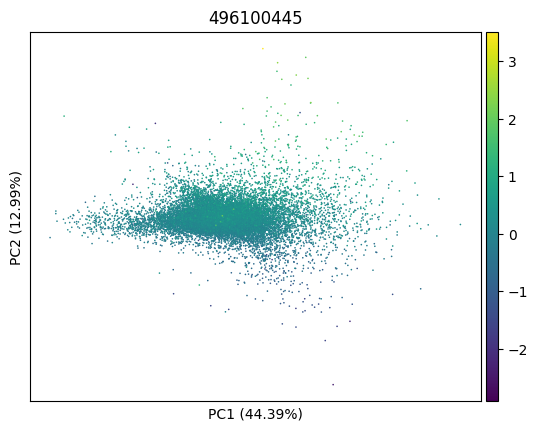

In [ ]:
scanpy_obj1.pca(gene_id = '496100445')

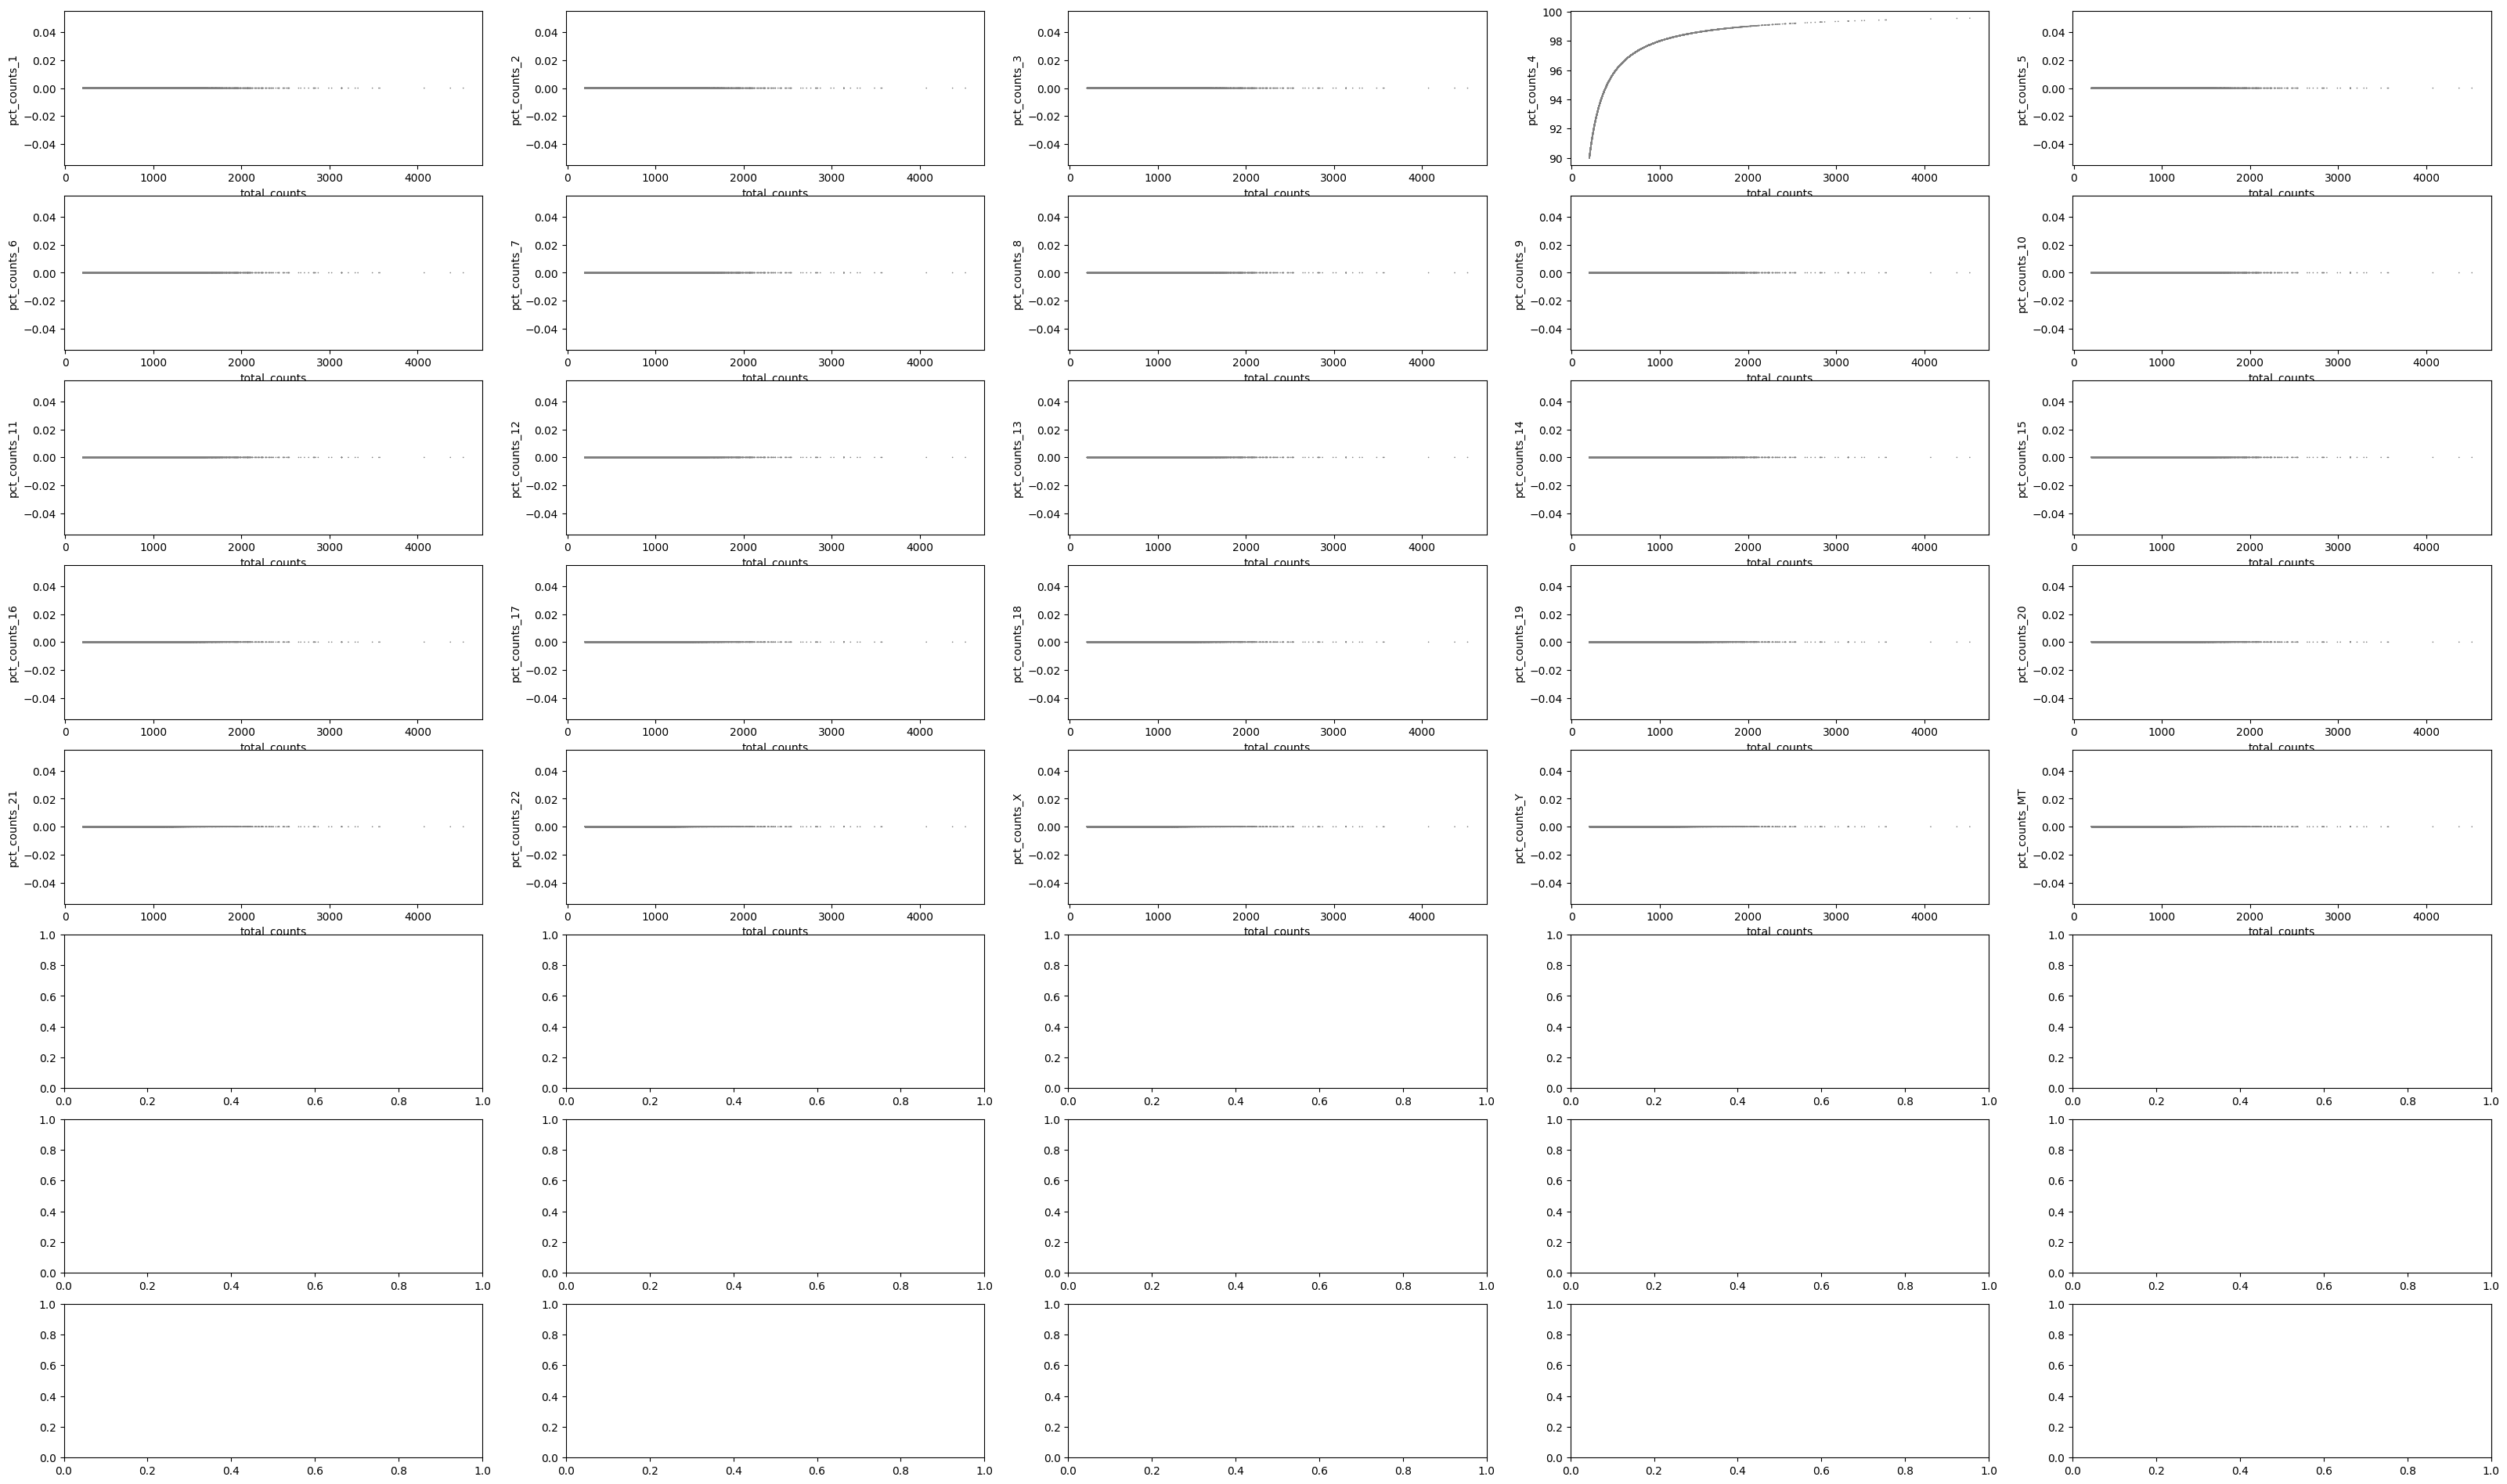

In [ ]:
scanpy_obj1.scatter_plots()

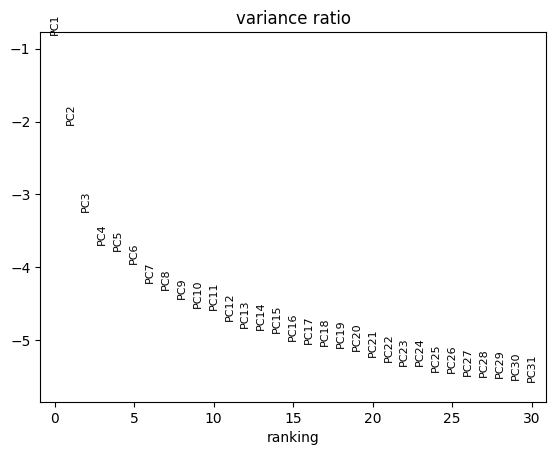

In [ ]:
scanpy_obj1.plot_pca_variance_ratio()

In [ ]:
scanpy_obj1.marker_genes()

{0: ['496100277', '496100625'],
 1: ['496100596', '496100511'],
 2: ['496100362', '496100589'],
 3: ['496100455', '496100501'],
 4: ['496100278', '496100485'],
 5: ['496100484', '496100639'],
 6: ['496100514', '496100640'],
 7: ['496100616', '496100653'],
 8: ['496100352', '496100523'],
 9: ['496100554', '496100646'],
 10: ['496100409', '496100358'],
 11: ['496100611', '496100536'],
 12: ['496100527', '496100614'],
 13: ['496100474', '496100660'],
 14: ['496100317', '496100452']}

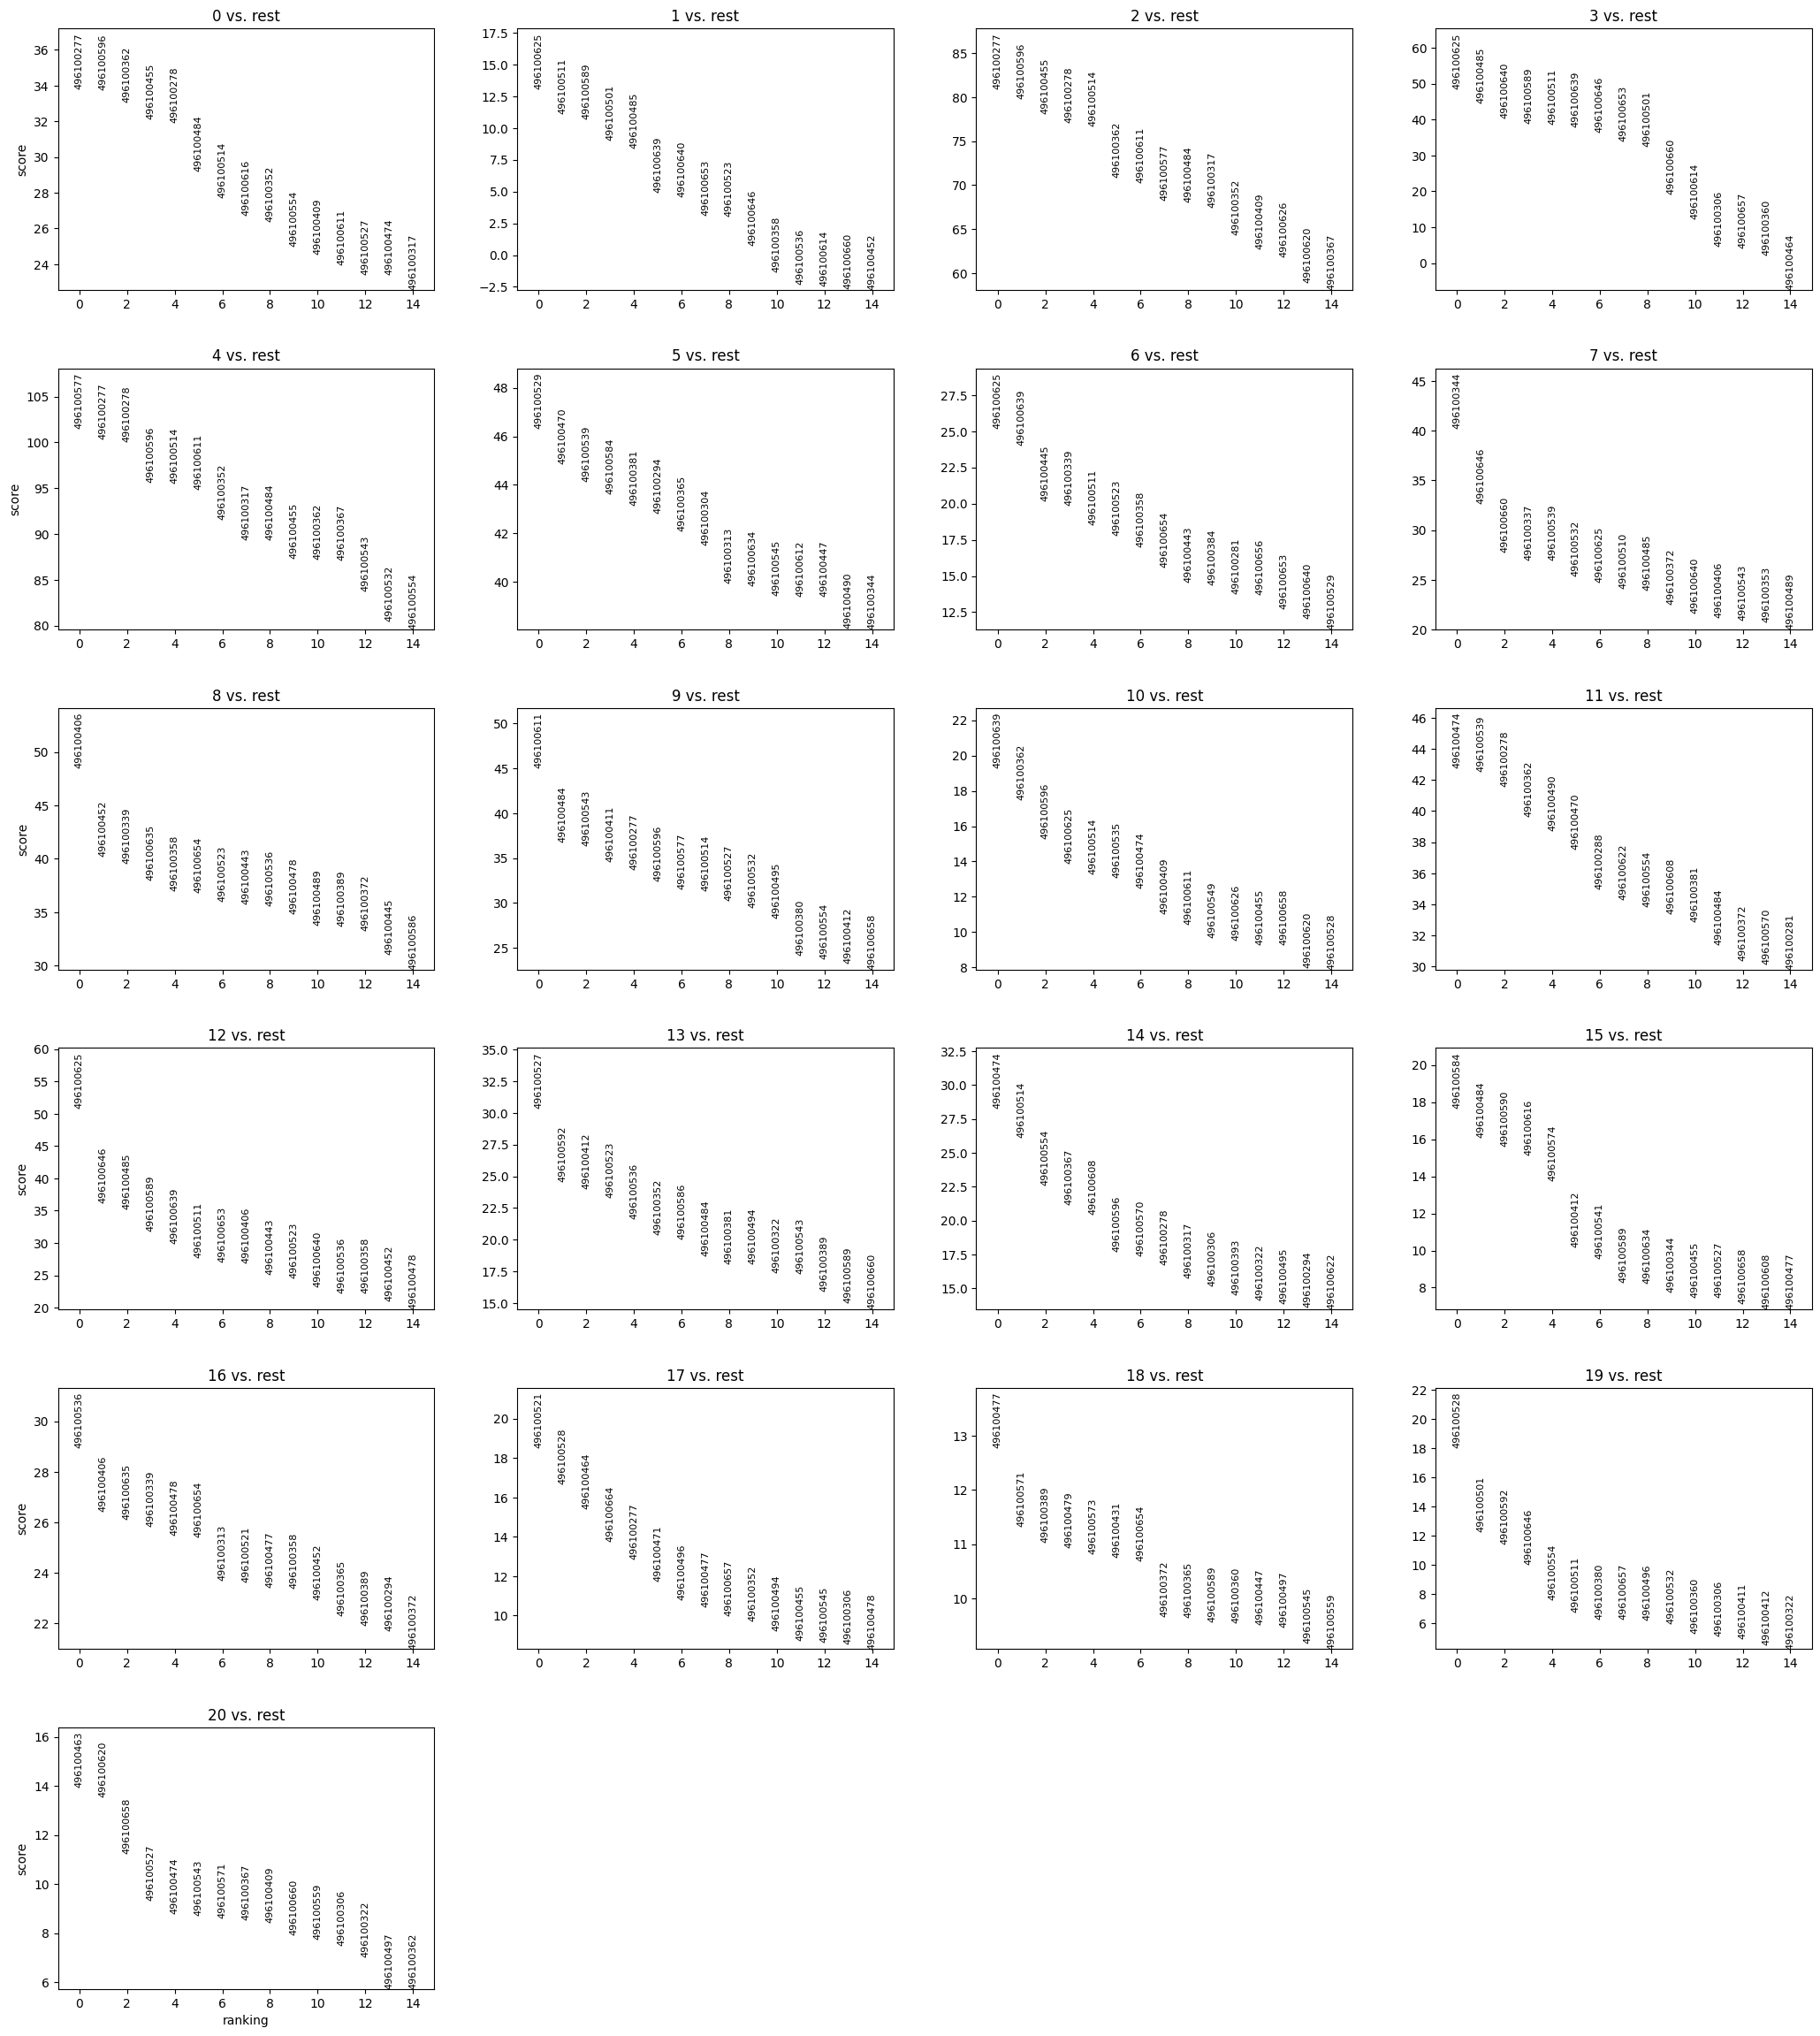

In [ ]:
scanpy_obj1.leiden_ranking()

In [ ]:
rows_genes.where(rows_genes['chromosome'] == '15').dropna()

,gene_id,chromosome,gene_entrez_id,gene_symbol,gene_name
35544,499340285.0,15,101059971.0,LOC101059971,101059971
35545,499340286.0,15,390531.0,IGHV1OR15-9,immunoglobulin heavy variable 1/OR15-9 (non-fu...
35546,499340287.0,15,646052.0,SLC20A1P3,solute carrier family 20 (phosphate transporte...
35547,499340288.0,15,100287128.0,IGHV1OR15-2,immunoglobulin heavy variable 1/OR15-2 (pseudo...
35548,499340289.0,15,105379210.0,LOC105379210,Ig heavy chain V-III region VH26-like
...,...,...,...,...,...
37251,499342010.0,15,100124412.0,FAM138E,"family with sequence similarity 138, member E"
37252,499342011.0,15,100422834.0,MIR1302-10,microRNA 1302-10
37253,499342012.0,15,374666.0,WASH3P,WAS protein family homolog 3 pseudogene
37254,499342013.0,15,102465910.0,MIR6859-3,microRNA 6859-3


In [ ]:
# rows_genes['gene_id']['499304660']
target = 496100445
index  = rows_genes.where(rows_genes['gene_id'] == target).dropna()
index

,gene_id,chromosome,gene_entrez_id,gene_symbol,gene_name


In [ ]:
data

,donor_name,specimen_id,specimen_name,rna_well_id,polygon_id,structure_id,structure_acronym,structure_color,structure_name,hemisphere
rnaseq_profile_id,,,,,,,,,,
488395315,H14.09.030,309357843,H14.09.030.TCx.01,395325172,320817998,10235,TCx,#ebbfd0,temporal neocortex,left
496100277,H14.09.004,309357624,H14.09.004.PCx.01,320630866,310967169,10557,FWM,#f2f1f0,white matter of forebrain,right
496100278,H14.09.001,309357596,H14.09.001.PCx.01,320630834,310790571,10557,FWM,#f2f1f0,white matter of forebrain,left
496100279,H14.09.001,309357599,H14.09.001.TCx.01,320630838,310790522,10235,TCx,#ebbfd0,temporal neocortex,left
496100281,H14.09.002,309357603,H14.09.002.HIP.01,320630842,310790372,10294,HIP,#bfb5d5,hippocampus (hippocampal formation),right
...,...,...,...,...,...,...,...,...,...,...
496100667,H15.09.103,467179071,H15.09.103.TCx.01,482655826,480366830,10235,TCx,#ebbfd0,temporal neocortex,right
496100669,H15.09.103,467179068,H15.09.103.PCx.01,482655822,480363830,10557,FWM,#f2f1f0,white matter of forebrain,right
496100670,H15.09.107,467179104,H15.09.107.TCx.01,482655780,480363840,10235,TCx,#ebbfd0,temporal neocortex,right


In [ ]:
data.loc[target]

donor_name                                    H14.09.052
specimen_id                                    309358017
specimen_name                          H14.09.052.HIP.01
rna_well_id                                    472517891
polygon_id                                     470531240
structure_id                                       10294
structure_acronym                                    HIP
structure_color                                  #bfb5d5
structure_name       hippocampus (hippocampal formation)
hemisphere                                         right
Name: 496100445, dtype: object